In [1]:
from jedi import settings
settings.case_insensitive_completion = True

In [1]:

from SRC.utils import constants
from SRC.utils.logger import APP_Logger
from SRC.utils.common_utils import get_null_percent , sep_column_dtypes , reduce_memory_usage

In [2]:
# !pip install xgboost
# !pip install optuna

In [2]:
lg = APP_Logger("Ruuning_log")

In [3]:
import os 
import pandas as pd
import numpy as np
import seaborn as sns
import shutil
import pickle
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from datetime import datetime
from warnings import filterwarnings
from pandas_profiling import ProfileReport
from sklearn.feature_selection import RFE
#***************************************************************************************************#
from sklearn.preprocessing import MinMaxScaler , LabelEncoder , StandardScaler , OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
#***************************************************************************************************#
from sklearn.metrics import mean_squared_error , mean_absolute_error , explained_variance_score , r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression ,ElasticNet , ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
import optuna
#***************************************************************************************************#

sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)
pd.options.display.max_columns = 200
%matplotlib inline
filterwarnings('ignore')

In [4]:
df = pd.read_csv(constants.RAW_DATA_URL) # reading raw data from url 
display(df.head())

,manufacturer_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_type,engine_capacity,body_type,has_warranty,ownership,type_of_drive,is_exchangeable,number_of_photos,number_of_maintenance,duration_listed,price_usd
0,Volkswagen,automatic,black,130000,2016,diesel,diesel,1.6,universal,False,owned,front,True,17,38,67,13150.0
1,Renault,manual,brown,149000,2012,gasoline,gasoline,1.6,sedan,False,owned,front,False,9,3,100,7500.0
2,Kia,automatic,brown,110000,2014,gasoline,gasoline,1.6,hatchback,False,owned,front,False,5,10,91,12200.0
3,Opel,automatic,other,255100,2007,gasoline,gasoline,1.8,hatchback,False,owned,front,False,10,4,91,4950.0
4,Mazda,manual,blue,650000,1999,gasoline,gasoline,2.0,sedan,False,owned,front,True,5,7,62,3000.0


In [6]:
df = reduce_memory_usage(df)

Memory usage decreased from 26.86MB to 1.39MB (25.46MB, 94.82% reduction)


In [7]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   manufacturer_name      50000 non-null  category
 1   transmission           50000 non-null  category
 2   color                  50000 non-null  category
 3   odometer_value         50000 non-null  int32   
 4   year_produced          50000 non-null  int16   
 5   engine_fuel            50000 non-null  category
 6   engine_type            50000 non-null  category
 7   engine_capacity        49985 non-null  float32 
 8   body_type              50000 non-null  category
 9   has_warranty           50000 non-null  bool    
 10  ownership              50000 non-null  category
 11  type_of_drive          50000 non-null  category
 12  is_exchangeable        50000 non-null  bool    
 13  number_of_photos       50000 non-null  int8    
 14  number_of_maintenance  50000 non-null 

None

In [8]:
get_null_percent(df)

,null,percent
manufacturer_name,0,0.0000
transmission,0,0.0000
color,0,0.0000
odometer_value,0,0.0000
year_produced,0,0.0000
engine_fuel,0,0.0000
engine_type,0,0.0000
engine_capacity,15,0.0003
body_type,0,0.0000
has_warranty,0,0.0000


1. Engine capacity has 15 null values so we can drop the values as its 0.0003 percentage of total values - lets take a closer look

In [9]:
data = df.copy()

display(data[data.isnull().any(axis=1)]) # checking for null values in dataframe
display(data[data.isnull().any(axis=1)].shape) # conifirm the number 

,manufacturer_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_type,engine_capacity,body_type,has_warranty,ownership,type_of_drive,is_exchangeable,number_of_photos,number_of_maintenance,duration_listed,price_usd
4171,Fiat,automatic,orange,49000,2014,electric,electric,NaN,hatchback,False,owned,front,False,18,1,11,16000.0
6808,Nissan,automatic,white,57357,2015,electric,electric,NaN,hatchback,False,owned,front,False,20,57,75,13850.0
13927,Fiat,automatic,orange,49000,2014,electric,electric,NaN,hatchback,False,owned,front,False,18,1,11,16000.0
15761,Nissan,automatic,black,84000,2014,electric,electric,NaN,hatchback,False,owned,front,False,12,19,138,14500.0
17362,Fiat,automatic,orange,27000,2013,electric,electric,NaN,hatchback,False,owned,front,True,11,13,77,14900.0
21708,Fiat,automatic,orange,27000,2013,electric,electric,NaN,hatchback,False,owned,front,True,11,13,77,14900.0
27661,BMW,automatic,other,67000,2018,electric,electric,NaN,liftback,False,owned,rear,False,6,2,57,39999.0
29655,Nissan,automatic,white,50000,2014,electric,electric,NaN,hatchback,False,owned,front,False,12,7,18,12900.0
31396,BMW,automatic,white,54150,2015,electric,electric,NaN,hatchback,False,owned,rear,True,23,17,18,24750.0
35316,BMW,automatic,other,67000,2018,electric,electric,NaN,liftback,False,owned,rear,False,6,2,57,39999.0


(15, 17)

Interesting the engine_fuel and engine type is electric for all the cars with NAN

In [10]:
display(data[data['engine_type'] == "electric"].shape[0]) #total number of electric cars

15

All the columns with null values are: electric and we wont be able to drop the NAN value 

In [11]:
display(data[data['engine_type'] == "electric"]['manufacturer_name'].value_counts()) # total number of electric cars by manufacturer

Nissan           6
BMW              4
Fiat             4
Chevrolet        1
Acura            0
Seat             0
Mercedes-Benz    0
Mini             0
Mitsubishi       0
Opel             0
Peugeot          0
Pontiac          0
Porsche          0
Renault          0
Rover            0
Saab             0
SsangYong        0
Skoda            0
Lincoln          0
Subaru           0
Suzuki           0
Toyota           0
Volkswagen       0
Volvo            0
ВАЗ              0
ГАЗ              0
ЗАЗ              0
Москвич          0
Mazda            0
Lexus            0
Lifan            0
Geely            0
Audi             0
Buick            0
Cadillac         0
Chery            0
Chrysler         0
Citroen          0
Dacia            0
Daewoo           0
Dodge            0
Ford             0
Great Wall       0
Alfa Romeo       0
Honda            0
Hyundai          0
Infiniti         0
Iveco            0
Jaguar           0
Jeep             0
Kia              0
LADA             0
Lancia      

In [12]:
display(data[data['engine_type'] == "electric"]['body_type'].value_counts()) # total number of electric cars by body type

hatchback    12
liftback      3
cabriolet     0
coupe         0
limousine     0
minibus       0
minivan       0
pickup        0
sedan         0
suv           0
universal     0
van           0
Name: body_type, dtype: int64

In [13]:
display(data['body_type'].value_counts()) # total number of cars by body type

sedan        16910
hatchback     9923
universal     7151
suv           6677
minivan       4720
minibus       1760
van           1052
coupe          842
liftback       703
pickup         155
cabriolet       92
limousine       15
Name: body_type, dtype: int64

We will use KNN Imputer based on the number of neigebors as the total number of unquie values in each in body_type 

In [14]:
data["Nan_gudie_engine_capacity"] = df["engine_capacity"].isna() # creating a new column to check if engine_capacity is null or not

In [15]:
data["Nan_gudie_engine_capacity"].value_counts() # checking the number of null values in engine type

False    49985
True        15
Name: Nan_gudie_engine_capacity, dtype: int64

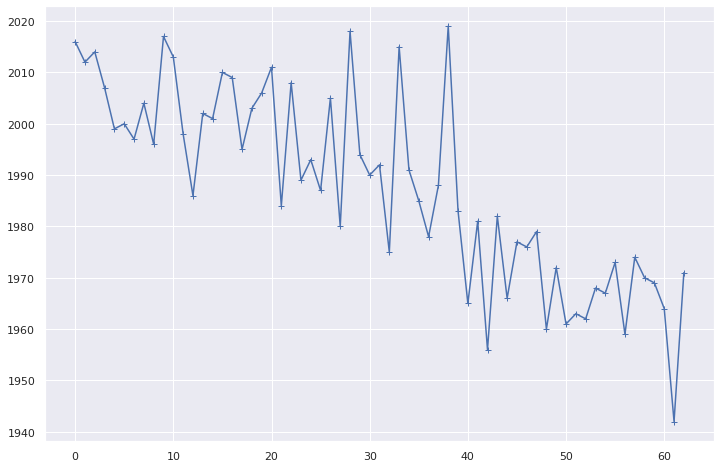

In [16]:
plt.figure(figsize=(12,8))
plt.plot(data['year_produced'].unique() , marker = '+') # checking the unique values in year_produced

In [17]:
totalyears = data['year_produced'].unique()
currentyear = datetime.now().year
display(f'current:{currentyear}')
display(f'The oldest car is {currentyear- min(totalyears)}') # checking the difference between max and min year
display(f'The newest car is {currentyear - max(totalyears)}') # checking the difference between current year and min year

'current:2022'

'The oldest car is 80'

'The newest car is 3'

We  note that the age of the oldest car is 77 years old and the youngest car is 3 years old.

Most Goverenments dont allow cars ages more than 10 years to register - The car beyond 20 years are more like collectibles. so for this we analysis we will use 25 years as the max age. 

In [18]:
q1 = data['year_produced'].quantile(0.25)
q2 = data['year_produced'].quantile(0.5)
q3 = data['year_produced'].quantile(0.75)

iqr = q3 - q1

upper_bound = q3 + 1.5 * iqr
lower_bound = q1 - 1.5 * iqr

display(f'upper_bound:{upper_bound} and lower_bound:{lower_bound} , q1:{q1} , q2:{q2} , q3:{q3}')

'upper_bound:2025.5 and lower_bound:1981.5 , q1:1998.0 , q2:2003.0 , q3:2009.0'

In [19]:
CAR_MAX_AGE_YEAR = currentyear - 25 # setting the max age of car to 25 years

display(CAR_MAX_AGE_YEAR)

1997

In [20]:
display(data[data['year_produced'] >= CAR_MAX_AGE_YEAR].shape) # checking the number of cars with age greater than 25 years
display(data[data['year_produced'] < CAR_MAX_AGE_YEAR].shape) # checking the number of cars with age less than 25 years

(39926, 18)

(10074, 18)

In [21]:
data_new = data[data['year_produced'] >= CAR_MAX_AGE_YEAR] # creating a new dataframe with cars with age greater than 25 years
data_old = data[data['year_produced'] < CAR_MAX_AGE_YEAR] # creating a new dataframe with cars with age less than 25 years

<AxesSubplot:>

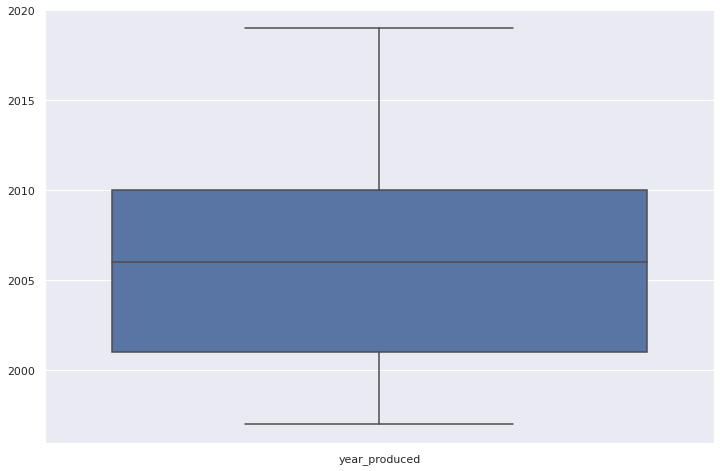

In [22]:
plt.figure(figsize=(12,8))
sns.boxplot(data = data_new [['year_produced']]) # checking the distribution of year_produced

<AxesSubplot:xlabel='price_usd', ylabel='Count'>

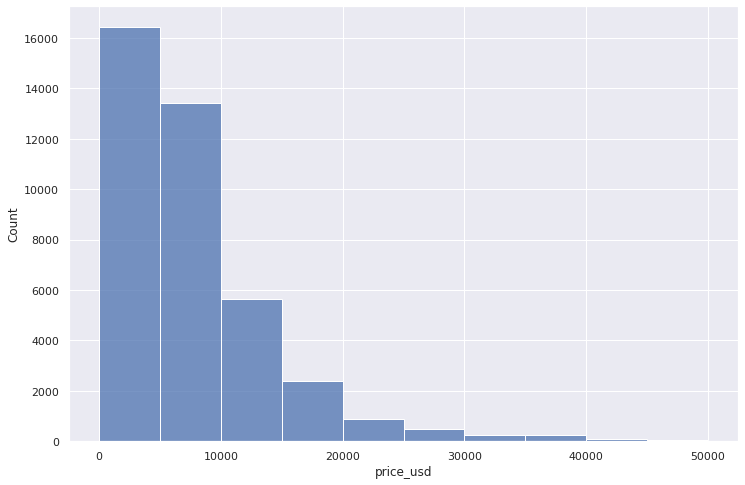

In [23]:
plt.figure(figsize=(12,8))
sns.histplot(data = data_new , x = 'price_usd' , bins = 10) # checking the distribution of year_produced

In [24]:
currentyear = datetime.now().year
CAR_MAX_AGE_YEAR = currentyear - 25 # setting the max age of car to 25 years

display(CAR_MAX_AGE_YEAR)

1997

In [25]:
df = df[df['year_produced'] >= CAR_MAX_AGE_YEAR] # creating a new dataframe with cars with age greater than 25 years

lg.info("Data with age greater than 25 years  has been dropped and we have {} rows".format(df.shape[0]))


Data with age greater than 25 years  has been dropped and we have 39926 rows


In [26]:
df.to_csv(constants.RAW_FILE_NAME , index = False) # saving the dataframe to csv file

PreProccseing 

In [27]:
df = pd.read_csv(constants.RAW_FILE_NAME) # reading the csv file

In [28]:
profile = ProfileReport(df, title='Pandas Profiling Report_pre_proccesing', html={'style':{'full_width':True}}) # creating a profile report
REPORT_FILE_NAME = os.path.join(constants.TEMPLATE_DIR, 'Pandas_Profiling_Report_pre_proccesing' + str(constants.CURRENT_TIME_STAMP)+'.html')

In [29]:
profile.to_file(REPORT_FILE_NAME) # saving the profile report to html file

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset has 12928 (32.4%) duplicate rows

In [30]:
df.duplicated().sum() # checking the number of duplicated rows

12965

In [31]:
DUMP_DIR = os.path.join(constants.ARIFACTS_DIR, 'DATA_DUMP')
os.makedirs(DUMP_DIR, exist_ok=True)

In [32]:
data = df.duplicated()

data.to_csv(os.path.join(DUMP_DIR , 'duplicate_data' + constants.CURRENT_TIME_STAMP + '.csv') ,  index = False) # saving the dataframe to csv file

lets frop the dupilcate and keep the first occurance 

In [33]:
df[df.duplicated()]["price_usd"].value_counts().sort_values() # checking the duplicated rows

15150.00      1
2836.75       1
10899.00      1
35999.00      1
8583.89       1
           ... 
3000.00     162
4000.00     168
4500.00     172
5500.00     187
3500.00     197
Name: price_usd, Length: 1449, dtype: int64

In [34]:
df[df["price_usd"] == 15150]

,manufacturer_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_type,engine_capacity,body_type,has_warranty,ownership,type_of_drive,is_exchangeable,number_of_photos,number_of_maintenance,duration_listed,price_usd
35247,Renault,manual,silver,128000,2016,diesel,diesel,1.5,suv,False,owned,front,False,23,27,44,15150.0
39916,Renault,manual,silver,128000,2016,diesel,diesel,1.5,suv,False,owned,front,False,23,27,44,15150.0


In [35]:
df[df.duplicated()]["price_usd"].value_counts().sample(40) # checking the duplicated rows

260.00        1
30600.00      1
1199.00       4
7066.30       1
7899.00       5
18600.00      4
23475.29      1
6890.00       3
7900.00      51
28136.68      1
8633.00       1
10650.00      4
8555.00       2
22200.00      3
5400.00      30
3000.00     162
7256.00       2
17465.62      1
34900.00      2
9300.00      38
29900.00      3
5264.16       1
13400.00     12
2250.00      25
16598.68      2
20690.00      1
3777.00       1
17826.52      1
12286.11      1
32200.00      1
12150.00      2
5500.00     187
2666.00       1
12450.00      5
43999.00      1
4700.00      89
27500.00      9
2892.91       1
2809.00       1
49500.00      1
Name: price_usd, dtype: int64

In [36]:
df[df["price_usd"] == 1050.000000]

,manufacturer_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_type,engine_capacity,body_type,has_warranty,ownership,type_of_drive,is_exchangeable,number_of_photos,number_of_maintenance,duration_listed,price_usd
709,Lifan,manual,silver,222350,2011,gasoline,gasoline,1.6,sedan,False,owned,front,False,8,1,38,1050.0
2598,Citroen,manual,silver,220000,1997,diesel,diesel,1.9,hatchback,False,owned,front,True,11,3,68,1050.0
4662,Daewoo,manual,yellow,166000,2001,gasoline,gasoline,0.8,hatchback,False,owned,front,False,5,1,76,1050.0
5757,Kia,automatic,blue,485000,1998,gasoline,gasoline,2.0,sedan,False,owned,front,False,4,1,55,1050.0
6781,Citroen,manual,silver,400000,1999,diesel,diesel,1.9,universal,False,owned,front,False,7,2,84,1050.0
6846,Mitsubishi,manual,white,251000,1999,gasoline,gasoline,1.3,universal,False,owned,front,False,6,4,44,1050.0
9690,Lifan,manual,silver,222350,2011,gasoline,gasoline,1.6,sedan,False,owned,front,False,8,1,38,1050.0
11199,Citroen,manual,silver,220000,1997,diesel,diesel,1.9,hatchback,False,owned,front,True,11,3,68,1050.0
11507,Renault,manual,green,302000,1997,gasoline,gasoline,1.6,sedan,False,owned,front,False,5,19,46,1050.0
11642,Daewoo,manual,yellow,166000,2001,gasoline,gasoline,0.8,hatchback,False,owned,front,False,5,1,76,1050.0


In [37]:
df = reduce_memory_usage(df)

Memory usage decreased from 21.44MB to 1.11MB (20.33MB, 94.81% reduction)


In [38]:
catgeories_columns, boolan_columns, numeric_columns = sep_column_dtypes(df)

# we will use the master colum to drop the vaLUEs BY DROPING THE PRICE COLUMN


In [39]:
FEATURE_COLUMNS = df.drop(columns = ['price_usd'] , axis = 1).columns.tolist()

In [40]:
df.shape , len(FEATURE_COLUMNS)

((39926, 17), 16)

In [41]:
data = df[df.duplicated( keep='first')]
display(data.shape)

(12965, 17)

In [42]:
master_duplicate_index = data.index

In [43]:
len(master_duplicate_index)

12965

In [44]:
data1 = df[df.duplicated(FEATURE_COLUMNS)]
display(data1.shape)

(13070, 17)

In [45]:
Feature_duplicate_index = data1.index
len(Feature_duplicate_index)

13070

In [46]:
difference_index = [index for index in Feature_duplicate_index if index not in master_duplicate_index]

In [47]:
difference_index_master = [index for index in master_duplicate_index if index not in Feature_duplicate_index]

In [48]:
len(difference_index) , len(difference_index_master)

(105, 0)

In [49]:
df.iloc[difference_index]['odometer_value'].value_counts()

0         104
250000      1
Name: odometer_value, dtype: int64

In [50]:
df.iloc[difference_index].groupby(['manufacturer_name','odometer_value']).count()

transmission  color  year_produced  \
manufacturer_name odometer_value                                       
Acura             0                          0      0              0   
                  250000                     0      0              0   
Alfa Romeo        0                          0      0              0   
                  250000                     0      0              0   
Audi              0                          0      0              0   
...                                        ...    ...            ...   
ГАЗ               250000                     0      0              0   
ЗАЗ               0                          0      0              0   
                  250000                     0      0              0   
УАЗ               0                          0      0              0   
                  250000                     0      0              0   

                                  engine_fuel  engine_type  engine_capacity  \
manufacturer_name odometer_value                                              
Acura             0                         0            0                0   
                  250000                    0            0                0   
Alfa Romeo        0                         0            0                0   
                  250000                    0            0                0   
Audi              0                         0            0                0   
...                                       ...          ...              ...   
ГАЗ               250000                    0            0                0   
ЗАЗ               0                         0            0                0   
                  250000                    0            0                0   
УАЗ               0                         0            0                0   
                  250000                    0            0                0   

                                  body_type  has_warranty  ownership  \
manufacturer_name odometer_value                                       
Acura             0                       0             0          0   
                  250000                  0             0          0   
Alfa Romeo        0                       0             0          0   
                  250000                  0             0          0   
Audi              0                       0             0          0   
...                                     ...           ...        ...   
ГАЗ               250000                  0             0          0   
ЗАЗ               0                       0             0          0   
                  250000                  0             0          0   
УАЗ               0                       0             0          0   
                  250000                  0             0          0   

                                  type_of_drive  is_exchangeable  \
manufacturer_name odometer_value                                   
Acura             0                           0                0   
                  250000                      0                0   
Alfa Romeo        0                           0                0   
                  250000                      0                0   
Audi              0                           0                0   
...                                         ...              ...   
ГАЗ               250000                      0                0   
ЗАЗ               0                           0                0   
                  250000                      0                0   
УАЗ               0                           0                0   
                  250000                      0                0   

                                  number_of_photos  number_of_maintenance  \
manufacturer_name odometer_value                                            
Acura             0                              0                      0   
                

In [51]:
df = df.drop_duplicates( keep = 'first') # dropping the duplicated rows

In [52]:
catgeories_columns

['manufacturer_name',
 'transmission',
 'color',
 'engine_fuel',
 'engine_type',
 'body_type',
 'ownership',
 'type_of_drive']

Odometer has a lot of o Values lets check thoose 
Zeros	563 
Zeros (%)	1.4%

In [53]:
df[df['odometer_value'] == 0]['year_produced'].value_counts()

2019    344
2018      6
2017      3
2016      1
Name: year_produced, dtype: int64

In [54]:
df[(df['odometer_value'] == 0)& (df['year_produced'] < 2019)]

,manufacturer_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_type,engine_capacity,body_type,has_warranty,ownership,type_of_drive,is_exchangeable,number_of_photos,number_of_maintenance,duration_listed,price_usd
3036,Ford,automatic,blue,0,2018,gasoline,gasoline,1.5,suv,True,new,all,True,13,6,27,23000.000000
5553,Hyundai,automatic,black,0,2018,gasoline,gasoline,1.6,suv,False,new,all,False,1,1,16,30304.470703
5832,Jeep,manual,grey,0,2016,diesel,diesel,2.8,suv,False,new,all,False,4,94,252,43000.000000
13680,Toyota,automatic,white,0,2017,gasoline,gasoline,1.8,sedan,False,new,front,True,20,3,40,15000.000000
15112,Mini,automatic,grey,0,2018,gasoline,gasoline,1.5,suv,False,new,all,False,28,53,66,39456.078125
16485,Jeep,automatic,orange,0,2017,gasoline,gasoline,1.4,suv,False,new,all,True,12,354,839,37224.000000
17675,Volkswagen,manual,black,0,2018,gasoline,gasoline,1.4,suv,True,new,front,True,10,1,1,19991.000000
31657,Renault,manual,silver,0,2018,gasoline,gasoline,1.6,suv,False,new,front,False,9,1,7,9500.000000
34057,Jeep,automatic,orange,0,2017,gasoline,gasoline,1.4,suv,False,new,all,False,9,330,773,34900.000000
36170,Skoda,automatic,grey,0,2018,gasoline,gasoline,2.0,suv,False,new,all,False,3,111,427,34000.000000


The number of maintenance don't corelate to new vehicle - 0 odometer value

In [55]:
df[df['odometer_value'] == 0].to_csv(os.path.join(DUMP_DIR , 'odometer_value_zero' + constants.CURRENT_TIME_STAMP + '.csv')) # saving the dataframe to csv file

<AxesSubplot:xlabel='number_of_photos', ylabel='price_usd'>

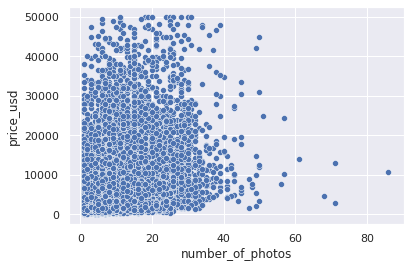

In [56]:
sns.scatterplot(data = df , x = 'number_of_photos' , y = 'price_usd')

NO realation ration is seen between the number of photos and price

In [57]:
PHOTOTHERSHOLD = df['number_of_photos'].quantile(0.70)
df['number_of_photos'] = df['number_of_photos'].apply(lambda x: x if x < PHOTOTHERSHOLD else PHOTOTHERSHOLD)

<AxesSubplot:xlabel='duration_listed', ylabel='price_usd'>

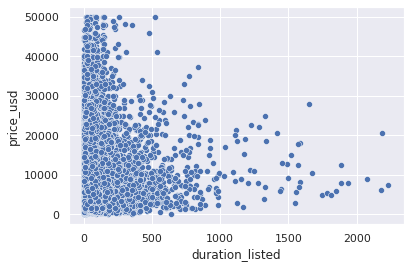

In [58]:
# duration_listed
sns.scatterplot(data = df , x = 'duration_listed' , y = 'price_usd')

In [59]:
MAIN_DURATION_THRESHOLD = df['duration_listed'].quantile(0.30)
display (MAIN_DURATION_THRESHOLD)
df['duration_listed'] = df['duration_listed'].apply(lambda x: x if x < MAIN_DURATION_THRESHOLD else MAIN_DURATION_THRESHOLD)

31.0

Lets do the analysis on the price

<AxesSubplot:>

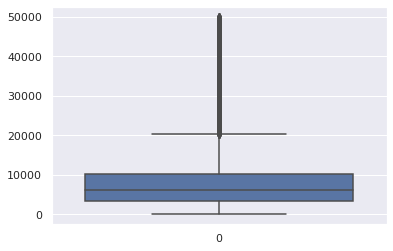

In [60]:
sns.boxplot(data= df['price_usd'])

In [61]:
FEATURE_COLUMNS

['manufacturer_name',
 'transmission',
 'color',
 'odometer_value',
 'year_produced',
 'engine_fuel',
 'engine_type',
 'engine_capacity',
 'body_type',
 'has_warranty',
 'ownership',
 'type_of_drive',
 'is_exchangeable',
 'number_of_photos',
 'number_of_maintenance',
 'duration_listed']

In [62]:
q1 = df['price_usd'].quantile(0.25)
q3 = df['price_usd'].quantile(0.75)
iqr = q3 - q1

upper_bound = q3 + 1.5*iqr
lower_bound = q1 - 1.5*iqr


In [63]:
df[df['price_usd']> upper_bound].groupby(['manufacturer_name' , 'engine_capacity' , 'body_type'])['price_usd'].mean()

manufacturer_name  engine_capacity  body_type
Acura              1.3              cabriolet   NaN
                                    coupe       NaN
                                    hatchback   NaN
                                    liftback    NaN
                                    limousine   NaN
                                                 ..
УАЗ                6.4              pickup      NaN
                                    sedan       NaN
                                    suv         NaN
                                    universal   NaN
                                    van         NaN
Name: price_usd, Length: 23976, dtype: float32

In [64]:
df[df['price_usd']> upper_bound]['engine_capacity'].unique()

array([2. , 3. , 3.7, 2.2, 4.6, 1.8, 3.5, 2.4, 2.5, 1.4, 1.6, 5.5, 6.2,
       4.5, 2.8, 3.6, 4.4, 2.3, 2.7, 1.3, 4. , 5.6, 4.2, 5. , 6. , 4.8,
       1.5, 5.7, 2.1, 4.7, 5.3, 3.2, 2.9, 5.2, 3.8, nan, 4.1, 6.4],
      dtype=float32)

In [65]:
df[(df['price_usd']> upper_bound) & (df['engine_capacity'] < 1.6)].head(50)

,manufacturer_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_type,engine_capacity,body_type,has_warranty,ownership,type_of_drive,is_exchangeable,number_of_photos,number_of_maintenance,duration_listed,price_usd
551,Skoda,manual,blue,0,2019,gasoline,gasoline,1.4,sedan,True,new,front,True,12.0,2,3.0,27071.990234
614,Skoda,automatic,blue,0,2019,gasoline,gasoline,1.4,sedan,True,new,front,True,12.0,1,2.0,23890.259766
871,Cadillac,automatic,black,57399,2014,hybrid-petrol,gasoline,1.4,coupe,False,owned,front,True,12.0,12,27.0,24999.000000
1282,Skoda,automatic,black,0,2019,gasoline,gasoline,1.4,sedan,True,new,front,True,12.0,1,2.0,23892.160156
1388,Cadillac,automatic,silver,64000,2013,hybrid-petrol,gasoline,1.4,coupe,False,owned,front,True,3.0,3,31.0,22289.669922
1960,Skoda,manual,black,0,2019,gasoline,gasoline,1.4,sedan,True,new,front,True,12.0,11,25.0,25848.900391
2279,Skoda,automatic,brown,0,2019,gasoline,gasoline,1.4,suv,True,new,front,True,12.0,10,26.0,26981.410156
2314,Skoda,automatic,green,0,2019,gasoline,gasoline,1.4,sedan,True,new,front,True,12.0,1,2.0,23826.710938
2388,Mercedes-Benz,automatic,silver,0,2019,gasoline,gasoline,1.3,sedan,False,new,front,False,12.0,2,3.0,34228.289062
3036,Ford,automatic,blue,0,2018,gasoline,gasoline,1.5,suv,True,new,all,True,12.0,6,27.0,23000.000000


In [66]:
df[(df['price_usd']> upper_bound) & (df['engine_capacity'] >3.6)].head(50)

,manufacturer_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_type,engine_capacity,body_type,has_warranty,ownership,type_of_drive,is_exchangeable,number_of_photos,number_of_maintenance,duration_listed,price_usd
174,Infiniti,automatic,brown,131000,2011,gasoline,gasoline,3.7,suv,False,owned,all,False,12.0,3,31.0,20700.000000
309,Lexus,automatic,black,106000,2010,gasoline,gasoline,4.6,suv,False,owned,all,True,12.0,77,31.0,26499.000000
943,Mercedes-Benz,automatic,black,305000,2005,gasoline,gasoline,5.5,suv,False,owned,all,False,12.0,3,31.0,27500.000000
1197,Mercedes-Benz,automatic,blue,76700,2008,gasoline,gasoline,6.2,sedan,False,owned,all,True,12.0,2,1.0,28500.000000
1200,Toyota,automatic,black,143000,2011,diesel,diesel,4.5,suv,False,owned,all,False,9.0,13,31.0,36500.000000
1483,Mercedes-Benz,automatic,grey,64338,2016,gasoline,gasoline,5.5,sedan,False,owned,all,False,12.0,27,31.0,49900.000000
1753,BMW,automatic,black,46300,2013,gasoline,gasoline,4.4,coupe,False,owned,all,False,12.0,13,31.0,34600.000000
2680,BMW,automatic,black,160000,2011,diesel,diesel,4.0,suv,False,owned,all,False,3.0,4,31.0,30990.000000
2750,Infiniti,automatic,other,150000,2013,gasoline,gasoline,5.6,suv,False,owned,all,False,12.0,2,2.0,22900.000000
2833,Toyota,manual,blue,284000,2009,diesel,diesel,4.2,suv,False,owned,all,False,8.0,3,31.0,36000.000000


Alll seems to be high end cars or pick up we will kepp it for now 

In [5]:
df.to_csv(constants.PROCCESED_FILE_NAME , index = False) # saving the dataframe to csv file

NameError: name 'df' is not defined

In [68]:

df_proceeded = pd.read_csv(constants.PROCCESED_FILE_NAME) # reading the csv file

In [69]:
df_proceeded.shape

(26961, 17)

In [70]:
df_proceeded = reduce_memory_usage(df_proceeded)

Memory usage decreased from 14.48MB to 0.88MB (13.59MB, 93.90% reduction)


In [71]:
catgeories_columns , boolan_columns , numeric_columns = sep_column_dtypes(df_proceeded)

In [72]:
X = df_proceeded.drop(columns = ['price_usd'] , axis = 1)
y = df_proceeded['price_usd']

In [73]:
X_encoded = pd.get_dummies(X)


In [74]:
NEIGHBORS = len(df['body_type'].unique())
imputer = KNNImputer(n_neighbors=NEIGHBORS)
X_imputed = imputer.fit_transform(X_encoded)

In [75]:
pickle.dump(imputer, open(os.path.join(constants.IMPUTER_FIle_NAME), 'wb'))

In [76]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

pickle.dump(scaler, open(os.path.join(constants.SCALER_FILE_NAME), 'wb'))

In [77]:
X_train , X_test , y_train , y_test = train_test_split(X_scaled , y , test_size = 0.2 , random_state = 42)

In [31]:
def model_result(modelname , model , X_test , y_test , counter ):
    """ Print the result of the model """

    y_pred = model.predict(X_test)
    result_dict = {}
    result_dict['Name'] = modelname
    result_dict['R2 score'] = model.score(X_test, y_test)
    result_dict['eV_score'] = explained_variance_score(y_test, y_pred)
    result_dict['RMSE'] = np.sqrt(mean_squared_error(y_test, y_pred))
    result_dict['MAE'] = mean_absolute_error(y_test, y_pred)
    result_dict['MSE'] = mean_squared_error(y_test, y_pred)
    df= pd.DataFrame(result_dict , columns= result_dict.keys() , index = [counter])
    # display(df)
    return df

In [ ]:
model_lr= LinearRegression()
elasticCV = ElasticNetCV(alphas = None, cv =10)
elasticCV.fit(X_train, y_train)
elasticnet_reg = ElasticNet(alpha = elasticCV.alpha_,l1_ratio=0.5)
model_svr= SVR(kernel='rbf', C=1e3, gamma=0.1)
model_rf = RandomForestRegressor(n_estimators=100, max_depth=2, random_state=0)
model_xgb= xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.4,
            max_depth = 30, alpha =1.18547,n_estimators = 200 )
master_result = pd.DataFrame()

model_lr.fit(X_train, y_train)
result = model_result('Linear Regression' , model_lr , X_test , y_test , 0)
master_result = master_result.append(result)


elasticnet_reg.fit(X_train, y_train)
result = model_result('Elastic Net' , elasticnet_reg.fit(X_train, y_train) , X_test , y_test , 1)
master_result = master_result.append(result)

model_svr.fit(X_train, y_train)
result = model_result('SVR' , model_svr , X_test , y_test , 2)
master_result = master_result.append(result)

model_rf.fit(X_train, y_train)
result = model_result('Random Forest' , model_rf , X_test , y_test , 3)
master_result = master_result.append(result)

model_xgb.fit(X_train, y_train)
result = model_result('XGBoost' , model_xgb , X_test , y_test , 4)
master_result = master_result.append(result)

pickle.dump(model_lr , open(os.path.join(constants.MODEL_DIR , 'LinearRegression.pkl'), 'wb'))
pickle.dump(elasticnet_reg, open(os.path.join(constants.MODEL_DIR , 'ElasticNet.pkl'), 'wb'))
pickle.dump(model_svr, open(os.path.join(constants.MODEL_DIR , 'SVR.pkl'), 'wb'))
pickle.dump(model_rf, open(os.path.join(constants.MODEL_DIR , 'RandomForest.pkl'), 'wb'))
pickle.dump(model_xgb, open(os.path.join(constants.MODEL_DIR , 'XGBoost.sav'), 'wb'))





In [ ]:
master_result

##Test data result 

In [ ]:
df = pd.read_csv(constants.TEST_DATA_URL)

In [ ]:
X = df_proceeded.drop(columns = ['price_usd'] , axis = 1)
y = df_proceeded['price_usd']
X_encoded = pd.get_dummies(X)
imputer = pickle.load(open(os.path.join(constants.IMPUTER_FIle_NAME), 'rb'))
X_imputed = imputer.transform(X_encoded)
scaler = pickle.load(open(os.path.join(constants.SCALER_FILE_NAME), 'rb'))
X_scaled = scaler.fit_transform(X_imputed)



model_result("XGBoost" , model_xgb , X_scaled , y , 1)


##lets try on the older Vechiles which we droped 

In [ ]:
df = pd.read_csv(constants.RAW_DATA_URL)

In [ ]:
df = df[df['year_produced'] < 1997]

In [ ]:
df.shape

In [ ]:
df.duplicated().sum()

In [ ]:
df = df.drop_duplicates( keep = 'first')

In [ ]:
df.shape

In [ ]:

X = df_proceeded.drop(columns = ['price_usd'] , axis = 1)
y = df_proceeded['price_usd']
X_encoded = pd.get_dummies(X)
imputer = pickle.load(open(os.path.join(constants.IMPUTER_FIle_NAME), 'rb'))
X_imputed = imputer.transform(X_encoded)
scaler = pickle.load(open(os.path.join(constants.SCALER_FILE_NAME), 'rb'))
X_scaled = scaler.fit_transform(X_imputed)



model_result("XGBoost" , model_xgb , X_scaled , y , 1)

In [ ]:
df['year_produced'].value_counts()

In [ ]:
model_xgb.feature_importances_

In [ ]:
importance = {}
for feature , imp in zip( X_encoded.columns, model_xgb.feature_importances_):
    importance[feature] = imp

In [ ]:
imp_df= pd.DataFrame(model_xgb.feature_importances_, index = X_encoded.columns )

In [ ]:
imp_df.sort_values(by = 0 , ascending =False).head(60)

Feature selection 

In [6]:
df_proceeded = pd.read_csv(constants.PROCCESED_FILE_NAME) 

In [7]:
df_proceeded.head()

,manufacturer_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_type,engine_capacity,body_type,has_warranty,ownership,type_of_drive,is_exchangeable,number_of_photos,number_of_maintenance,duration_listed,price_usd
0,Volkswagen,automatic,black,130000,2016,diesel,diesel,1.6,universal,False,owned,front,True,12.0,38,31.0,13150.0
1,Renault,manual,brown,149000,2012,gasoline,gasoline,1.6,sedan,False,owned,front,False,9.0,3,31.0,7500.0
2,Kia,automatic,brown,110000,2014,gasoline,gasoline,1.6,hatchback,False,owned,front,False,5.0,10,31.0,12200.0
3,Opel,automatic,other,255100,2007,gasoline,gasoline,1.8,hatchback,False,owned,front,False,10.0,4,31.0,4950.0
4,Mazda,manual,blue,650000,1999,gasoline,gasoline,2.0,sedan,False,owned,front,True,5.0,7,31.0,3000.0


In [8]:
df_proceeded = reduce_memory_usage(df_proceeded)

Memory usage decreased from 14.48MB to 0.88MB (13.59MB, 93.90% reduction)


Lets split the data 

In [9]:
X = df_proceeded.drop('price_usd' , axis = 1)
y = df_proceeded['price_usd']

In [10]:
catgeories_columns, boolan_columns, numeric_columns  = sep_column_dtypes(X)

In [11]:
label_encoder = LabelEncoder()

In [12]:
X[catgeories_columns] = X[catgeories_columns].apply(label_encoder.fit_transform)

In [13]:
X.shape

(26961, 16)

In [14]:
NEIGHBORS = len(df_proceeded['body_type'].unique())
imputer = KNNImputer(n_neighbors=NEIGHBORS)
X_imputed = imputer.fit_transform(X)

In [15]:
estimator = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.4,
            max_depth = 30, alpha =1.18547,n_estimators = 200 )
selector = RFE(estimator, n_features_to_select=10, step=1)

selector = selector.fit(X_imputed, y)


In [16]:
selector.support_

array([ True,  True, False,  True,  True,  True, False,  True,  True,
       False,  True,  True, False, False,  True, False])

In [17]:
selector.ranking_

array([1, 1, 6, 1, 1, 1, 7, 1, 1, 4, 1, 1, 2, 3, 1, 5])

In [18]:
for feature , rank in zip(X.columns ,selector.ranking_ ):
    print(f'{feature} \t Rank {rank}')

manufacturer_name 	 Rank 1
transmission 	 Rank 1
color 	 Rank 6
odometer_value 	 Rank 1
year_produced 	 Rank 1
engine_fuel 	 Rank 1
engine_type 	 Rank 7
engine_capacity 	 Rank 1
body_type 	 Rank 1
has_warranty 	 Rank 4
ownership 	 Rank 1
type_of_drive 	 Rank 1
is_exchangeable 	 Rank 2
number_of_photos 	 Rank 3
number_of_maintenance 	 Rank 1
duration_listed 	 Rank 5


In [19]:
rank_scaled = pd.DataFrame(selector.ranking_  , index = X.columns ,  columns = ["Rank"])

In [20]:
rank_scaled[rank_scaled['Rank'] == 1]

,Rank
manufacturer_name,1
transmission,1
odometer_value,1
year_produced,1
engine_fuel,1
engine_capacity,1
body_type,1
ownership,1
type_of_drive,1
number_of_maintenance,1


In [21]:
rank_scaled[rank_scaled['Rank'] > 1]

,Rank
color,6
engine_type,7
has_warranty,4
is_exchangeable,2
number_of_photos,3
duration_listed,5


In [22]:
RFAbestfeatures = rank_scaled[rank_scaled['Rank'] == 1].index

In [23]:
df_proceeded.head()

,manufacturer_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_type,engine_capacity,body_type,has_warranty,ownership,type_of_drive,is_exchangeable,number_of_photos,number_of_maintenance,duration_listed,price_usd
0,Volkswagen,automatic,black,130000,2016,diesel,diesel,1.6,universal,False,owned,front,True,12.0,38,31.0,13150.0
1,Renault,manual,brown,149000,2012,gasoline,gasoline,1.6,sedan,False,owned,front,False,9.0,3,31.0,7500.0
2,Kia,automatic,brown,110000,2014,gasoline,gasoline,1.6,hatchback,False,owned,front,False,5.0,10,31.0,12200.0
3,Opel,automatic,other,255100,2007,gasoline,gasoline,1.8,hatchback,False,owned,front,False,10.0,4,31.0,4950.0
4,Mazda,manual,blue,650000,1999,gasoline,gasoline,2.0,sedan,False,owned,front,True,5.0,7,31.0,3000.0


In [24]:
X = df_proceeded[RFAbestfeatures]
y = df_proceeded['price_usd']

In [25]:
X.head()

,manufacturer_name,transmission,odometer_value,year_produced,engine_fuel,engine_capacity,body_type,ownership,type_of_drive,number_of_maintenance
0,Volkswagen,automatic,130000,2016,diesel,1.6,universal,owned,front,38
1,Renault,manual,149000,2012,gasoline,1.6,sedan,owned,front,3
2,Kia,automatic,110000,2014,gasoline,1.6,hatchback,owned,front,10
3,Opel,automatic,255100,2007,gasoline,1.8,hatchback,owned,front,4
4,Mazda,manual,650000,1999,gasoline,2.0,sedan,owned,front,7


In [26]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26961 entries, 0 to 26960
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   manufacturer_name      26961 non-null  category
 1   transmission           26961 non-null  category
 2   odometer_value         26961 non-null  int32   
 3   year_produced          26961 non-null  int16   
 4   engine_fuel            26961 non-null  category
 5   engine_capacity        26952 non-null  float32 
 6   body_type              26961 non-null  category
 7   ownership              26961 non-null  category
 8   type_of_drive          26961 non-null  category
 9   number_of_maintenance  26961 non-null  int16   
dtypes: category(6), float32(1), int16(2), int32(1)
memory usage: 477.5 KB


In [27]:
X_encoded = pd.get_dummies(X)

In [28]:
NEIGHBORS = len(df_proceeded['body_type'].unique())
imputer = KNNImputer(n_neighbors=NEIGHBORS)
X_imputed = imputer.fit_transform(X_encoded)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

In [29]:
X_train , X_test , y_train , y_test = train_test_split(X_scaled , y , test_size = 0.2 , random_state = 42)

In [40]:
model_lr= LinearRegression()
elasticCV = ElasticNetCV(alphas = None, cv =10)
elasticCV.fit(X_train, y_train)
elasticnet_reg = ElasticNet(alpha = elasticCV.alpha_,l1_ratio=0.5)
model_svr= SVR(kernel='rbf', C=1e3, gamma=0.1)
model_rf = RandomForestRegressor(n_estimators=100, max_depth=2, random_state=0)
model_xgb= xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.4,
            max_depth = 30, alpha =1.18547,n_estimators = 200 )
master_result = pd.DataFrame()

model_lr.fit(X_train, y_train)
result = model_result('Linear Regression' , model_lr , X_test , y_test , 0)
master_result = master_result.append(result)


elasticnet_reg.fit(X_train, y_train)
result = model_result('Elastic Net' , elasticnet_reg.fit(X_train, y_train) , X_test , y_test , 1)
master_result = master_result.append(result)

model_svr.fit(X_train, y_train)
result = model_result('SVR' , model_svr , X_test , y_test , 2)
master_result = master_result.append(result)

model_rf.fit(X_train, y_train)
result = model_result('Random Forest' , model_rf , X_test , y_test , 3)
master_result = master_result.append(result)

model_xgb.fit(X_train, y_train)
result = model_result('XGBoost' , model_xgb , X_test , y_test , 4)
master_result = master_result.append(result)





In [ ]:
master_result 

In [ ]:
model_rf.feature_importances_

In [ ]:
randomforest_imp_feature = pd.DataFrame(model_rf.feature_importances_  , index = X_encoded.columns ,  columns = ["Feature _imp"])

In [ ]:
randomforest_imp_feature.sort_values(by = "Feature _imp" , ascending=False).head(30)

In [ ]:
randomforest_imp_feature.sort_values(by = "Feature _imp" , ascending=False).tail(60)

In [ ]:
XGB_imp_feature = pd.DataFrame(model_xgb.feature_importances_  , index = X_encoded.columns ,  columns = ["Feature _imp"])
XGB_imp_feature.sort_values(by = "Feature _imp" , ascending=False).tail(50)

In [ ]:
XGB_imp_feature = pd.DataFrame(model_xgb.feature_importances_  , index = X_encoded.columns ,  columns = ["Feature _imp"])
XGB_imp_feature.sort_values(by = "Feature _imp" , ascending=False).head(33)

In [34]:
x , y = X_scaled , y 

In [35]:
x.shape

(26961, 83)

In [36]:
# Define an objective function to be minimized.
def objective(trial):

    # Invoke suggest methods of a Trial object to generate hyperparameters.
    regressor_name = trial.suggest_categorical('classifier', ['SVR', 'RandomForest' , 'XG_boost'])
    if regressor_name == 'SVR':
        svr_c = trial.suggest_float('svr_c', 1e-10, 1e10, log=True)
        svr_g = trial.suggest_categorical('svr_g', ['scale' , 'auto'])
        svr_k = trial.suggest_categorical('svr_k', ['linear' ,'rbf'] )
        
        regressor_obj = SVR( kernel = svr_k , C=svr_c , gamma = svr_g)
    elif regressor_name == 'XG_boost':
        Xgb_b = trial.suggest_categorical('Xgb_b', ['gbtree' , 'dart'] )
        Xgb_objective = trial.suggest_categorical('Xgb_objective', ['reg:squarederror' , 'reg:squarederror' , ])
        
        Xgb_learning_rate =  trial.suggest_categorical('Xgb_learning_rate' , [.00001,.0003,.008,0.4,.02,.01,1,8])
        Xgb_alpha= trial.suggest_loguniform('Xgb_alpha' , 1e-4 , 10.0)
        Xgb_max_depth = trial.suggest_categorical('Xgb_max_depth', [3,4,10,11,12,30,24,50,25])
        Xgb_n_estimators = trial.suggest_categorical('Xgb_n_estimators', [300,400,100,500,250,100])
        
        
        
        regressor_obj = xgb.XGBRegressor(booster= Xgb_b,  objective =Xgb_objective,
                                         alpha = Xgb_alpha , 
                                                                                
                                         learning_rate = Xgb_learning_rate,
            max_depth = Xgb_max_depth,n_estimators = Xgb_n_estimators )
    else:
        rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32)
        
        rf_nestimators = trial.suggest_categorical('rf_nestimators', [300,400,100,500,250,100])
        
        regressor_obj = RandomForestRegressor(max_depth=rf_max_depth , 
                                                              n_estimators=rf_nestimators)

    
    X_train, X_val, y_train, y_val = train_test_split(x, y, random_state=0)

    regressor_obj.fit(X_train, y_train)
    y_pred = regressor_obj.predict(X_val)

    error = mean_absolute_error(y_val , y_pred)

    return error  # An objective value linked with the Trial object.



In [37]:
study = optuna.create_study(direction='minimize')  # Create a new study.
study.optimize(objective, n_trials=6)  # Invoke optimization of the objective function.


[I 2022-05-14 19:31:14,876] A new study created in memory with name: no-name-cc7e8192-0602-432e-ac59-496be9a979c7
[I 2022-05-15 03:33:05,724] Trial 0 finished with value: 1984.570747087951 and parameters: {'classifier': 'SVR', 'svr_c': 647280.7413184039, 'svr_g': 'auto', 'svr_k': 'linear'}. Best is trial 0 with value: 1984.570747087951.
[I 2022-05-15 03:34:12,053] Trial 1 finished with value: 1349.0943295890997 and parameters: {'classifier': 'SVR', 'svr_c': 8254.62645408003, 'svr_g': 'auto', 'svr_k': 'rbf'}. Best is trial 1 with value: 1349.0943295890997.
[I 2022-05-15 03:34:34,458] Trial 2 finished with value: 1600.4216053400123 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 7, 'rf_nestimators': 500}. Best is trial 1 with value: 1349.0943295890997.
[I 2022-05-15 03:35:19,756] Trial 3 finished with value: 1986.9616074739895 and parameters: {'classifier': 'SVR', 'svr_c': 5.714845259878089, 'svr_g': 'scale', 'svr_k': 'linear'}. Best is trial 1 with value: 1349.09432958909

In [38]:
study.best_trial.params

{'classifier': 'SVR',
 'svr_c': 11532.85333049489,
 'svr_g': 'scale',
 'svr_k': 'rbf'}

'classifier': 'SVR',
 'svr_c': 11532.85333049489,
 'svr_g': 'scale',
 'svr_k': 'rbf'